This notebook explores an idea for finding the scan offset when the precursor is absent and cannot be used as a guide.

In [135]:
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
from scipy.signal import correlate

In [9]:
database_name = '/home/daryl/processing/UPS2_200ng/UPS2_200ng.sqlite'

In [12]:
source_conn = sqlite3.connect(database_name)
features_df = pd.read_sql_query("select feature_id,base_peak_id from feature_base_peaks order by feature_id ASC;", source_conn)
source_conn.close()

In [287]:
feature_id = 2
base_peak_id = features_df[features_df.feature_id==feature_id].base_peak_id.values[0]

In [288]:
database_name = '/home/daryl/processing/UPS2_200ng/UPS2_200ng-features-1-368.sqlite'
source_conn = sqlite3.connect(database_name)
feature_base_peak_points_df = pd.read_sql_query("select point_id,mz,scan,intensity from summed_ms1_regions where feature_id={} and peak_id={} order by scan ASC".format(feature_id,base_peak_id), source_conn)
ms2_peak_points_df = pd.read_sql_query("select peak_id,point_id,mz,scan,intensity from summed_ms2_regions where feature_id={} order by peak_id,scan ASC;".format(feature_id), source_conn)
source_conn.close()

In [289]:
feature_base_peak_points_df

,point_id,mz,scan,intensity
0,1,547.312957,109,9919949
1,7,547.313411,110,12928399
2,13,547.313519,111,16181145
3,19,547.312952,112,19383790
4,25,547.312535,113,22415557
5,33,547.312680,114,24450555
6,41,547.312651,115,26345007
7,49,547.312786,116,30445635
8,57,547.312819,117,36063472
9,65,547.312813,118,38115850


In [290]:
ms2_peak_points_to_plot_df = ms2_peak_points_df[(ms2_peak_points_df.peak_id>=1000) & (ms2_peak_points_df.peak_id<=1100)]

In [291]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
# Rescale to values between 0 and 1 
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)

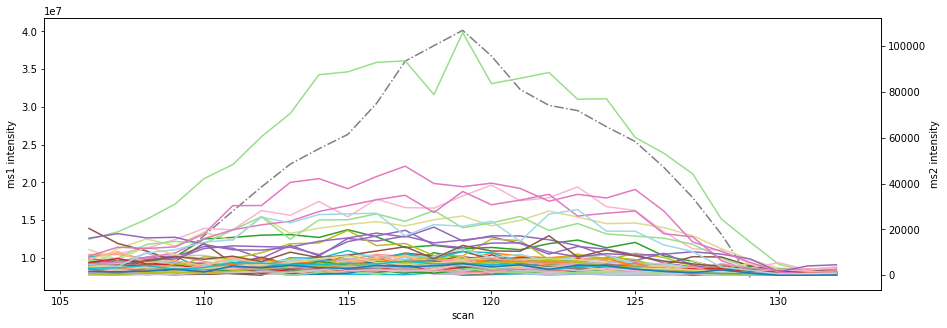

In [292]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(feature_base_peak_points_df.scan, feature_base_peak_points_df.intensity, marker='', linestyle='-.', ms=5, color='tab:gray', label='frame')
groups = ms2_peak_points_to_plot_df.groupby('peak_id')
for i, (name, group) in enumerate(groups):
    ax2.plot(group.scan, group.intensity, color=tableau20[i%len(tableau20)], label=name)
# plt.legend(loc='best')
ax1.set_ylabel('ms1 intensity')
ax1.set_xlabel('scan')
ax2.set_ylabel('ms2 intensity')
plt.margins(0.06)
plt.show()

In [293]:
ms2_peak_df = ms2_peak_points_df.loc[(ms2_peak_points_df.peak_id==2),['scan','intensity']]

In [294]:
base_peak_df = feature_base_peak_points_df[['scan','intensity']]

In [295]:
combined_df = pd.merge(base_peak_df, ms2_peak_df, on='scan', how='outer', suffixes=('_base', '_ms2')).sort_values(by='scan')
combined_df.intensity_base.fillna(0, inplace=True)
combined_df.intensity_base = combined_df.intensity_base.astype(int)

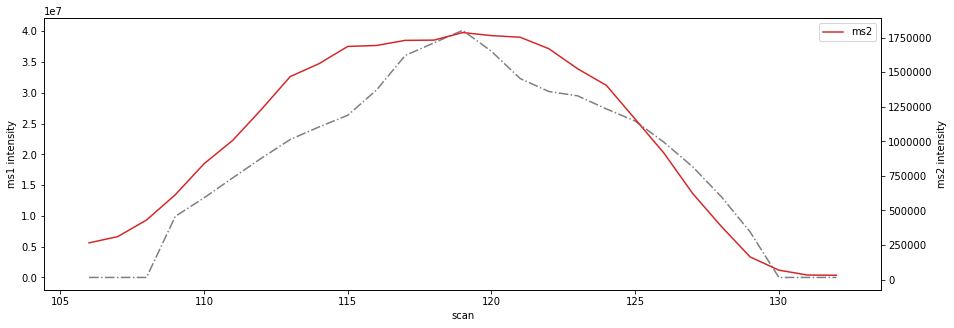

In [296]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(combined_df.scan, combined_df.intensity_base, marker='', linestyle='-.', ms=5, color='tab:gray', label='base')
ax2.plot(combined_df.scan, combined_df.intensity_ms2, marker='', linestyle='-', ms=5, color='tab:red', label='ms2')
plt.legend(loc='best')
ax1.set_ylabel('ms1 intensity')
ax1.set_xlabel('scan')
ax2.set_ylabel('ms2 intensity')
plt.margins(0.06)
plt.show()

In [297]:
offset = np.argmax(correlate(combined_df.intensity_base, combined_df.intensity_ms2)) - (len(combined_df.intensity_base)-1)  # wrt indexes
offset

1

In [298]:
from scipy.ndimage.interpolation import shift
adjusted_intensity_ms2 = shift(combined_df.intensity_ms2, offset, cval=0)

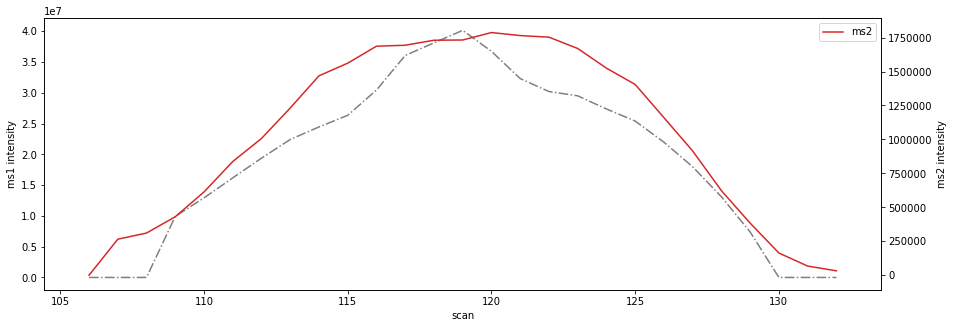

In [299]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(combined_df.scan, combined_df.intensity_base, marker='', linestyle='-.', ms=5, color='tab:gray', label='base')
ax2.plot(combined_df.scan, adjusted_intensity_ms2, marker='', linestyle='-', ms=5, color='tab:red', label='ms2')
plt.legend(loc='best')
ax1.set_ylabel('ms1 intensity')
ax1.set_xlabel('scan')
ax2.set_ylabel('ms2 intensity')
plt.margins(0.06)
plt.show()

### Plot a histogram of ms2 peak shift

In [300]:
source_conn = sqlite3.connect(database_name)
ms2_peaks_df = pd.read_sql_query("select peak_id from ms2_peaks where feature_id={} order by peak_id ASC;".format(feature_id), source_conn)
source_conn.close()

In [301]:
ms2_peaks_df["offset"] = 0
for index,row in ms2_peaks_df.iterrows():
    ms2_peak_df = ms2_peak_points_df.loc[(ms2_peak_points_df.peak_id==row.peak_id),['scan','intensity']]
    combined_df = pd.merge(base_peak_df, ms2_peak_df, on='scan', how='outer', suffixes=('_base', '_ms2')).sort_values(by='scan')
    combined_df.intensity_base.fillna(0, inplace=True)
    combined_df.intensity_base = combined_df.intensity_base.astype(int)
    row.offset = np.argmax(correlate(combined_df.intensity_base, combined_df.intensity_ms2)) - (len(combined_df.intensity_base)-1)

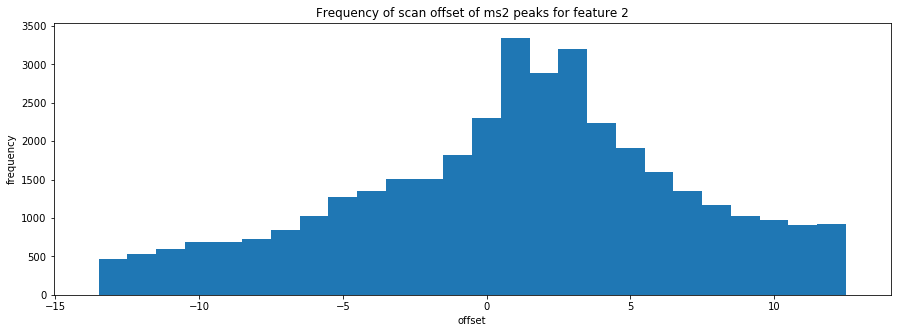

In [302]:
fig, ax1 = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(15)
plt.hist(ms2_peaks_df.offset, bins=np.arange(ms2_peaks_df.offset.min(), ms2_peaks_df.offset.max()+1), align='left')
plt.legend(loc='best')
plt.xlabel('offset')
plt.ylabel('frequency')
plt.title('Frequency of scan offset of ms2 peaks for feature {}'.format(feature_id))
plt.margins(0.06)
plt.show()